In [14]:
from ti_experiments.train_model_concat_ti import main

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from models import Transformer
from ti_experiments.configs.cfg_iw import config as default_config
from ti_experiments.train_model_concat_ti import eval_at_all_distances
from itertools import product
from sklearn.decomposition import PCA
from plotting_utils import TI_per_pair_plot
import adjustText

sns.set_context("paper", font_scale=3)

metrics = main(default_config, wandb_proj='iw_transinf', seed=42)

iters = np.arange(0, default_config.train.niters, default_config.log.logging_interval)



Config parameters: {'model': {'pos_dim': 0, 'emb_dim': 64, 'n_heads': 4, 'n_blocks': 2, 'include_mlp': False, 'activation': 'relu', 'n_mlp_layers': None, 'apply_ln': True, 'widening_factor': 1, 'max_T': 32, 'out_dim': 1, 'drop_p': 0.2, 'pos_emb_loc': 'none', 'prediction_mode': 'regress', 'pos_emb_type': 'onehot', 'pos_emb_randomization': 'no_shift', 'add_pos_encodings': True}, 'data': {'D': 64}, 'seq': {'ways': 7, 'shots': 1, 'N': None, 'B': 4, 'train_seq_type': 'iw', 'leave_one_out': False, 'include_distal_in_training': False, 'add_distractors_for_iw_seqs': False}, 'train': {'batch_size': 128, 'learning_rate': 9.87608117559501e-06, 'w_decay': 0.0, 'lr_scheduler': 'warmup_constant', 'warmup_steps': 3241, 'niters': 14000, 'steps_above_criterion': 10}, 'log': {'log_to_wandb': False, 'logging_interval': 200, 'checkpoint_interval': 5000, 'checkpoint_dir': 'checkpoints', 'wandb_project': 'in-context-trans-inf-hyperparam-search', 'run_name': None}, 'save_weights': False, 'save_hiddens': Fals

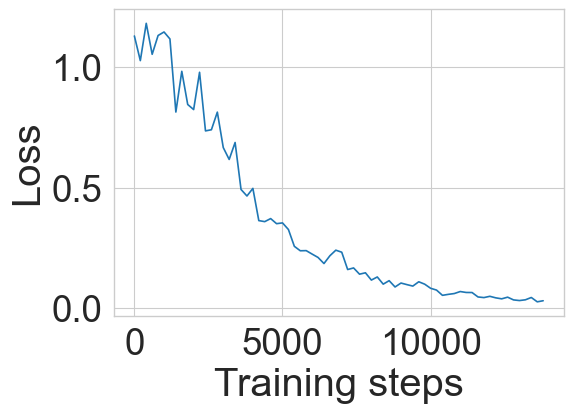

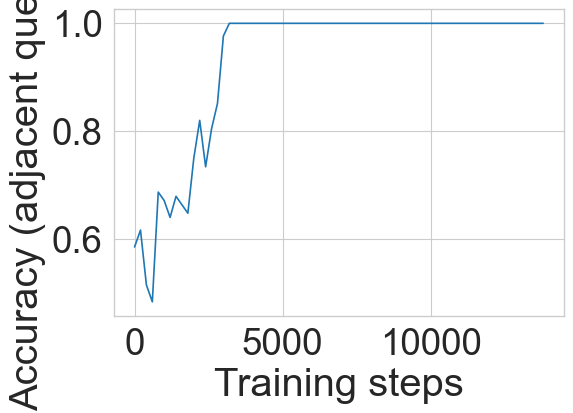

In [15]:
fig, ax = plt.subplots()
plt.plot(iters, metrics['loss'])
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.savefig('loss.png')
plt.show()

fig, ax = plt.subplots()
plt.plot(iters, metrics['holdout_accuracy'])
plt.ylabel('Accuracy (adjacent queries)')
plt.xlabel('Training steps')
plt.tight_layout()
plt.savefig('accuracy.png')
plt.show()


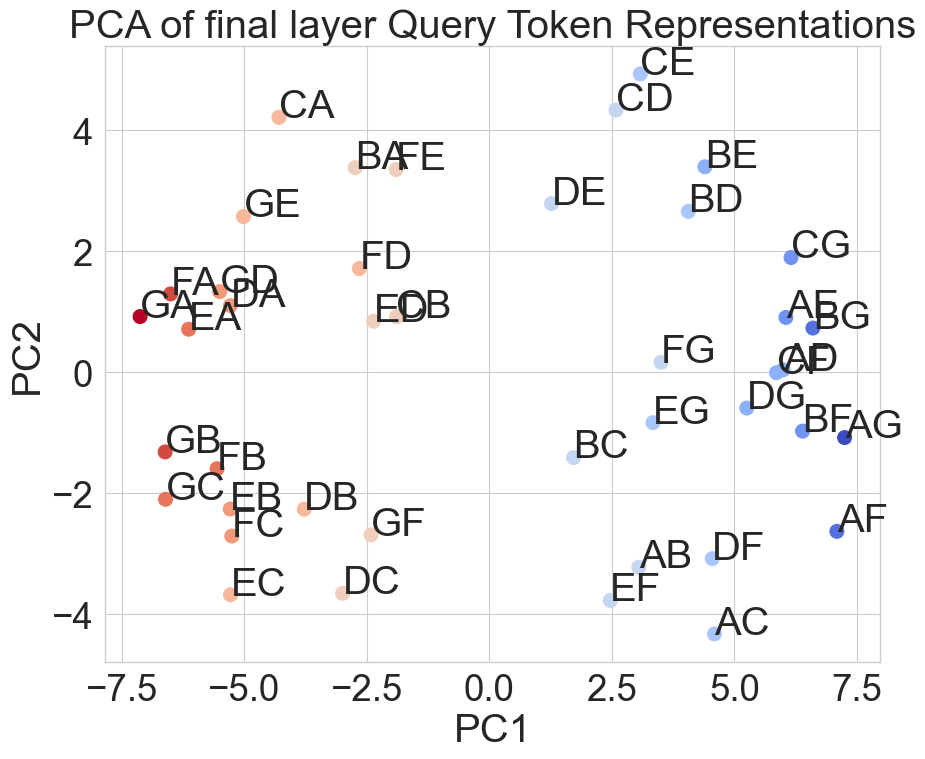

In [16]:



cfg = default_config
cfg.log.log_to_wandb = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg.model.out_dim = 1
model_dir = '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/uuh8wjk6/'
model_path = os.path.join(model_dir, 'model_5000.pt')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")
items = torch.load(os.path.join(model_dir, 'fixed_items.pt'))

model = Transformer(config=default_config.model)
model.load_state_dict(torch.load(model_path))
model.eval()

correct_matrix, holdout_batch, pred_matrix, ranks, model_activations = eval_at_all_distances(cfg,
                                                                                             device,
                                                                                             model,
                                                                                             5000,
                                                                                             get_hiddens=True,
                                                                                             leave_one_out=True,
                                                                                             items=items)

# Example ranks
item_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']  # Replace with your actual ranks

# Generate the labels for off-diagonal elements
labels = []
symb_distance = []
for i, j in product(ranks, ranks):
    if i == j:
        continue  # Skip diagonal elements (AA, BB, etc.)
    label = item_labels[i] + item_labels[j]  # Concatenate to form labels like 'AB', 'AC', etc.
    labels.append(label)
    symb_distance.append(i-j)


len(model_activations)

final_token_activations = [model_activations[i]['hidden_activations'][-1].mean(axis=0)[-1].detach() for i in range(len(model_activations))]
final_token_activations = np.array([np.array(i) for i in final_token_activations])


pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(final_token_activations)  # Shape: [P, 2]

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=symb_distance, cmap='coolwarm', s=100)

# Add labels for each point
for i, inp in enumerate(labels):
    plt.annotate(inp, (X_pca[i, 0], X_pca[i, 1]))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of final layer Query Token Representations')
plt.grid(True)
plt.show()


In [17]:
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"Variance explained by PC2: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"Total variance explained: {sum(explained_variance):.4f} ({sum(explained_variance)*100:.2f}%)")



Variance explained by PC1: 0.4088 (40.88%)
Variance explained by PC2: 0.1064 (10.64%)
Total variance explained: 0.5152 (51.52%)


3


<Axes: title={'center': 'Model Predictions by Symbolic Distance'}, xlabel='Query Pair', ylabel='Prediction Value'>

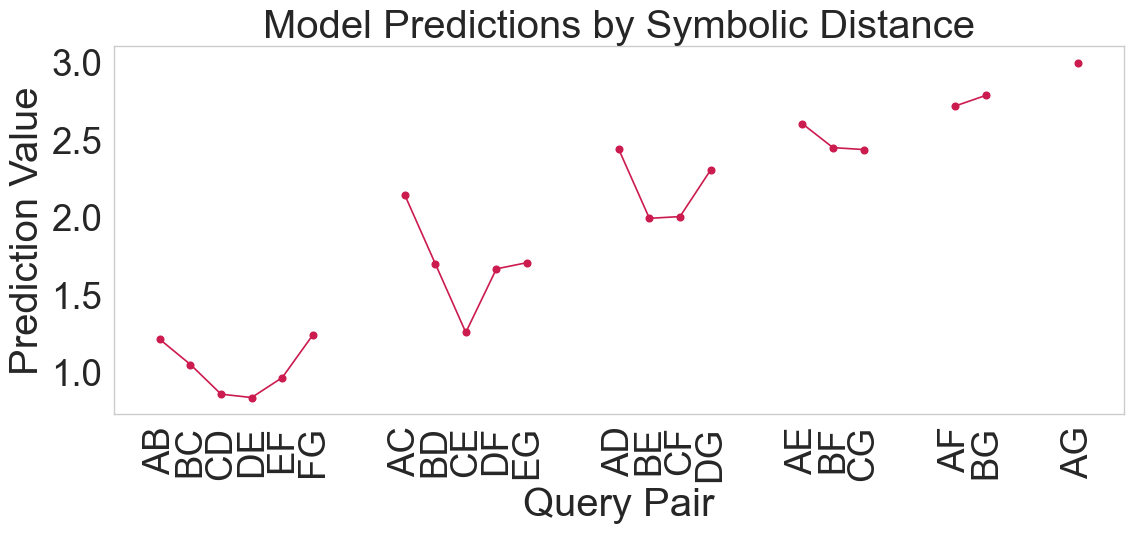

In [18]:
TI_per_pair_plot(pred_matrix)

3


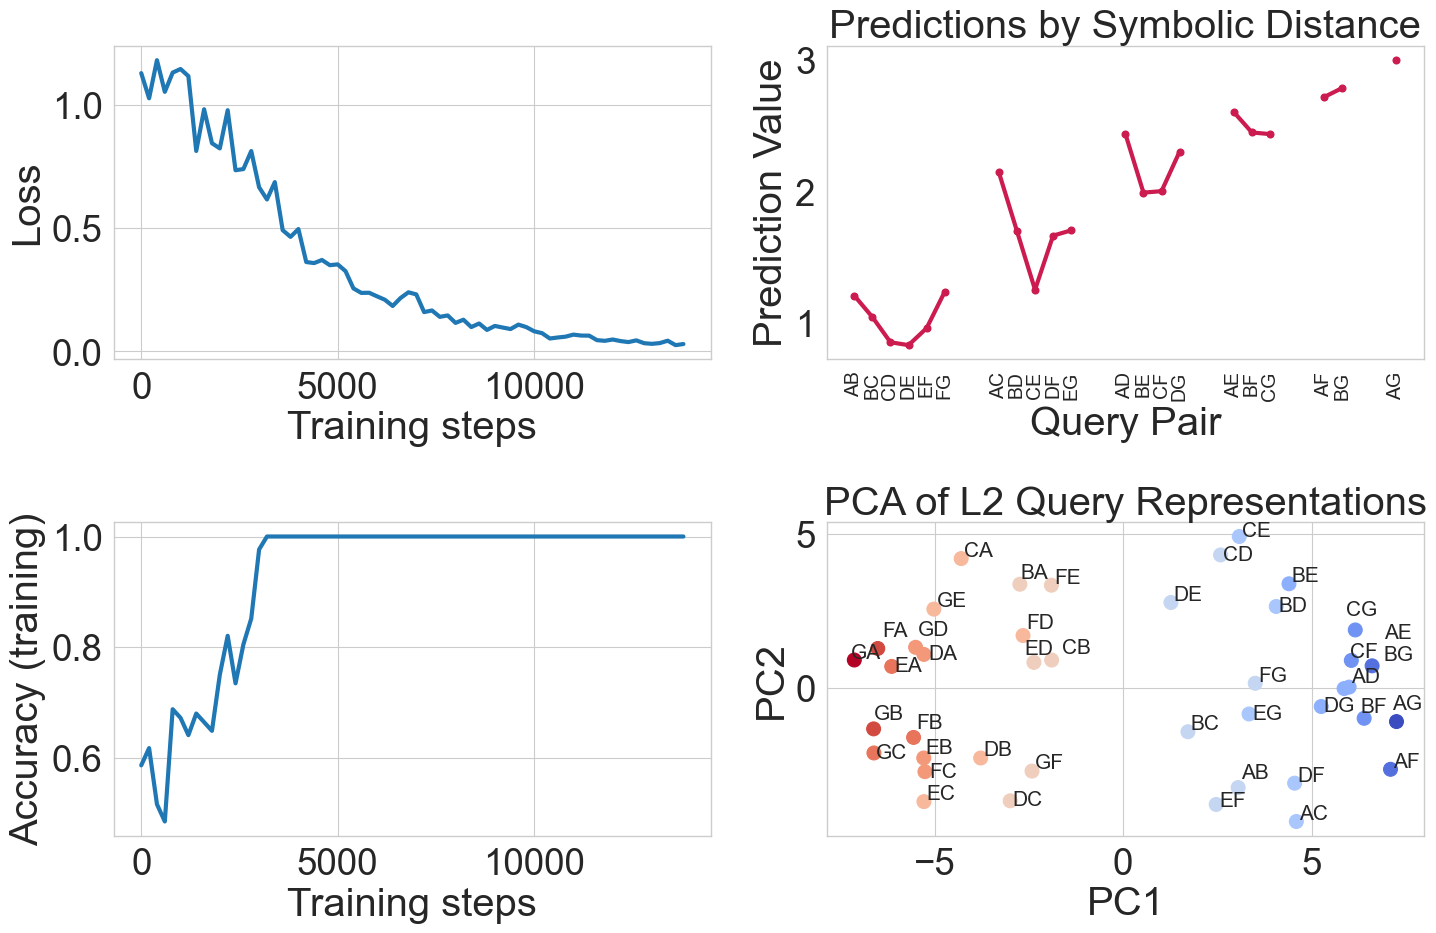

In [22]:
sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 3})

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

axs[0].plot(iters, metrics['loss'])
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training steps')

TI_per_pair_plot(pred_matrix, ax=axs[1])
axs[1].tick_params(axis='x', labelsize=14)  # x-axis tick labels
axs[1].set_title('Predictions by Symbolic Distance')

axs[2].plot(iters, metrics['holdout_accuracy'])
axs[2].set_ylabel('Accuracy (training)')
axs[2].set_xlabel('Training steps')

plt.sca(axs[3])
axs[3].scatter(X_pca[:, 0], X_pca[:, 1], c=symb_distance, cmap='coolwarm', s=100)

# Add labels for each point
txts = []
for i, inp in enumerate(labels):
    txt = plt.annotate(inp, (X_pca[i, 0], X_pca[i, 1]), fontsize=15)
    txts.append(txt)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of L2 Query Representations')

adjustText.adjust_text(txts)
plt.tight_layout()

plt.savefig('iw_transinf.pdf')

In [1]:
# train N times